In [13]:
import pandas as pd

from ultralytics import YOLO
import torch
from torch import library, utils, hub
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
# from utils import save_model

import os
from pathlib import Path

from custom_dataloader import groceries_DataLoader
from train_function import train_data


from typing import Tuple, Dict, List

torch.manual_seed(420)

# Set device agnostic code  
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda': torch.cuda.empty_cache()
device

'cuda'

## Retraining the Model on a Groceries Dataset

Getting list of files and subdirectories in the current directory

In [14]:
# Generating file list
path = '/Users/mralw/Desktop/MPHY0049/ML_Stuff/GroceryStoreDataset-master/dataset/train'
file_list = []

for root, dirs, files in os.walk(path):
    # print('Root : ', root)
    # print('Dirs : ', dirs)
    # print('Files : ', files)
    for file in files:
        file_list.append(os.path.join(root, file))
   
# print(file_list)
print(len(file_list))

# generating folder list
path = '/Users/mralw/Desktop/MPHY0049/ML_Stuff/GroceryStoreDataset-master/dataset/train'
folder_list = []

for root, dirs, files in os.walk(path):
#     print('Root : ', root)
#     print('Dirs : ', dirs)
#     print('Files : ', files)

    if len(dirs) > 0:
        folder_list.append(dirs)
        
# print(folder_list)
print(len(folder_list))


2640
20


In [15]:
## Load the pretrained model
from ultralytics import YOLO

# Load a pretrained YOLO model (recommended for training)
model = YOLO('yolov8n-cls.pt')

use groceries dataloader

In [16]:
import csv
MODELS_FOLDER = Path("models")
MODEL_SAVE_PATH = MODELS_FOLDER / "groceries.pth" # Importing based on the path name

### Groceries Model 

# Get path to grocery folders
image_path = Path('/Users/mralw/Desktop/MPHY0049/ML_Stuff/GroceryStoreDataset-master/dataset')
train_path = image_path / 'train'
test_path = image_path / 'val'

# get class names from csv
class_names = []
# Read the csv file and append the first column to class_names
with open(image_path / 'classes.csv', 'r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        class_names.append(row[0])



### Create datasets train, test, validation

# Instantiate the transforms
transformSequence = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()])

# batch_size and num_workers
BATCH_SIZE =  16 # at 64 for ResNet, turned down for others
NUM_WORKERS = os.cpu_count()

# Training Dataset
datasetTrain, datasetTest, class_names = groceries_DataLoader(
    train_dir = train_path,
    test_dir = test_path,
    transform = transformSequence,
    BATCH_SIZE = BATCH_SIZE,
    NUM_WORKERS = NUM_WORKERS)

# Adjust the fully connected layer to output only three classes
output_shape = len(class_names)
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.02, inplace=True),
    torch.nn.Linear(in_features=2048,
                    out_features=output_shape,
                    bias = True).to(device)
    )

# Set number of epochs
NUM_EPOCHS = 90
lr = 0.001


# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(),
                                lr=lr)


# Setup training loop
results = train_data(model = model,
                train_dataloader = datasetTrain,
                test_dataloader = datasetTest,
                optimizer = optimizer,
                loss_fn = loss_fn,
                epochs = NUM_EPOCHS,
                device = device)

# save_model(model=model,
#            target_dir='models',
#            model_name="1_cheXpert_15_epoch_VGG13_BN_6-Classes.pth")  # Change the model name with new experiment

  0%|          | 0/90 [00:00<?, ?it/s]

New https://pypi.org/project/ultralytics/8.1.9 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.8 🚀 Python-3.11.5 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=imagenet10, epochs=100, time=None, patience=50, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train20, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=

NotImplementedError: Could not run 'torchvision::nms' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'torchvision::nms' is only available for these backends: [CPU, Meta, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\cpu\nms_kernel.cpp:112 [kernel]
Meta: registered at /dev/null:440 [kernel]
QuantizedCPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\quantized\cpu\qnms_kernel.cpp:124 [kernel]
BackendSelect: fallthrough registered at ..\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:154 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ..\aten\src\ATen\functorch\DynamicLayer.cpp:498 [backend fallback]
Functionalize: registered at ..\aten\src\ATen\FunctionalizeFallbackKernel.cpp:324 [backend fallback]
Named: registered at ..\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ..\aten\src\ATen\ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at ..\aten\src\ATen\native\NegateFallback.cpp:19 [backend fallback]
ZeroTensor: registered at ..\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:86 [backend fallback]
AutogradOther: registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:53 [backend fallback]
AutogradCPU: registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:57 [backend fallback]
AutogradCUDA: registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:65 [backend fallback]
AutogradXLA: registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:69 [backend fallback]
AutogradMPS: registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:77 [backend fallback]
AutogradXPU: registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:61 [backend fallback]
AutogradHPU: registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:90 [backend fallback]
AutogradLazy: registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:73 [backend fallback]
AutogradMeta: registered at ..\aten\src\ATen\core\VariableFallbackKernel.cpp:81 [backend fallback]
Tracer: registered at ..\torch\csrc\autograd\TraceTypeManual.cpp:297 [backend fallback]
AutocastCPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:34 [kernel]
AutocastCUDA: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:27 [kernel]
FuncTorchBatched: registered at ..\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:720 [backend fallback]
BatchedNestedTensor: registered at ..\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:746 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ..\aten\src\ATen\functorch\VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at ..\aten\src\ATen\LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at ..\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ..\aten\src\ATen\functorch\TensorWrapper.cpp:203 [backend fallback]
PythonTLSSnapshot: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:162 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ..\aten\src\ATen\functorch\DynamicLayer.cpp:494 [backend fallback]
PreDispatch: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:166 [backend fallback]
PythonDispatcher: registered at ..\aten\src\ATen\core\PythonFallbackKernel.cpp:158 [backend fallback]


## Predicting using the Model

In [ ]:
results = model(['20Ounce_NYAS-Apples2.png'])

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    plot = result.plot()  # Matplotlib plot of predictions
    


0: 512x640 1 apple, 88.2ms
Speed: 7.0ms preprocess, 88.2ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


c:\Users\mralw\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


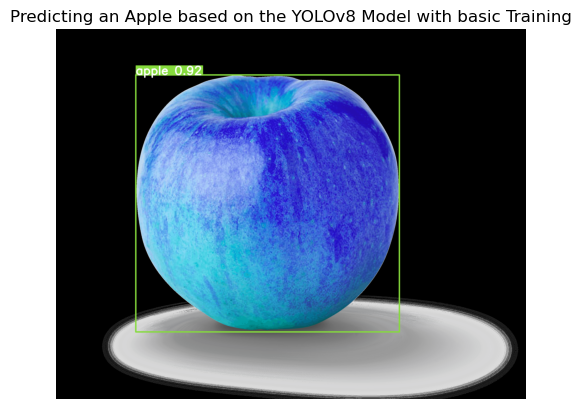

In [ ]:
from matplotlib import pyplot as plt 

# Assuming you have the image path and the result
image = '20Ounce_NYAS-Apples2.png'

# Load the image data
image_data = plt.imread(image)

# Plot the image
plt.imshow(plot)
plt.title("Predicting an Apple based on the YOLOv8 Model with basic Training")
plt.axis('off')

# Save the plot to the working directory
plt.savefig('plot.png')

# Show the plot
plt.show()

In [ ]:
## Loading the images
image_dir = "C:\\Users\\mralw\\Pictures"
image_list = []
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_list.append(filename)

results = model(image_list)

# Run batched inference on a list of images
# results = model(["C:\Users\mralw\Pictures\ach.jpg", "C:\Users\mralw\Pictures\cyclist.jpg", "C:\Users\mralw\Pictures\ppas2.jpg" ])  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs

NameError: name 'os' is not defined